In [128]:
import pandas as pd
import cv2
import numpy as np
import os

In [141]:
wiki = pd.read_csv('./Data/wiki5.csv')
wiki['pixels'] = wiki[wiki.columns[3:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
wiki_gender = wiki[['gender','pixels']]
wiki_gender.to_csv('./Data/wiki_gender.csv', index=False)

In [145]:
df = pd.read_csv('./Data/wiki_gender.csv')

In [172]:
for i in range(df.shape[0]):
    pic = list(eval(df.pixels[i]))
    pic = np.array(pic)
    pic = pic.reshape(100, 100)
    path = './Data/all'
    cv2.imwrite(os.path.join(path,'im'+str(i)+'.jpg'),pic)

In [146]:
df_male = df[df.gender == 1]
df_male = df_male.reset_index(drop=True)

In [147]:
df_female = df[df.gender == 0]
df_female = df_female.reset_index(drop=True)

In [148]:
for i in range(df_male.shape[0]):
    pic = list(eval(df_male.pixels[i]))
    pic = np.array(pic)
    pic = pic.reshape(100, 100)
    path = './Data/male'
    cv2.imwrite(os.path.join(path,'img'+str(i)+'.jpg'),pic)

In [149]:
for i in range(df_female.shape[0]):
    pic = list(eval(df_female.pixels[i]))
    pic = np.array(pic)
    pic = pic.reshape(100, 100)
    path = './Data/female'
    cv2.imwrite(os.path.join(path,'img'+str(i)+'.jpg'),pic)

In [152]:
import numpy as np
import json

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input

In [153]:
vgg16 = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 205s 0us/step


In [154]:
vgg16.save('vgg16.h5')

In [155]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [156]:
y = prepare_image('./Data/male/img1.jpg')

In [158]:
preds = vgg16.predict(y)

In [159]:
preds.shape

(1, 1000)

In [160]:
CLASS_INDEX = None

In [163]:
CLASS_INDEX_PATH = './imagenet-class-index.json'

In [169]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    
    CLASS_INDEX = json.load(open(CLASS_INDEX_PATH))
    
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x:x[2], reverse=True)
        results.append(result)
    return results

In [170]:
print(get_predictions(preds, top=5))

[[('n02883205', 'bow_tie', 0.14765672), ('n03929855', 'pickelhaube', 0.12779891), ('n03763968', 'military_uniform', 0.066628024), ('n02669723', 'academic_gown', 0.046626396), ('n04350905', 'suit', 0.04416566)]]


In [198]:
from collections import Counter, defaultdict
import os
import pickle as pk

In [195]:
def get_face_categories():
    d = defaultdict(float)
    img_list = os.listdir('./Data/all')
    for i, img_path in enumerate(img_list):
        img = prepare_image('./Data/all/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 100 == 0:
            print(i,'/', len(img_list), 'complete')
    return Counter(d)

In [196]:
cat_counter = get_face_categories()

0 / 3209 complete
100 / 3209 complete
200 / 3209 complete
300 / 3209 complete
400 / 3209 complete
500 / 3209 complete
600 / 3209 complete
700 / 3209 complete
800 / 3209 complete
900 / 3209 complete
1000 / 3209 complete
1100 / 3209 complete
1200 / 3209 complete
1300 / 3209 complete
1400 / 3209 complete
1500 / 3209 complete
1600 / 3209 complete
1700 / 3209 complete
1800 / 3209 complete
1900 / 3209 complete
2000 / 3209 complete
2100 / 3209 complete
2200 / 3209 complete
2300 / 3209 complete
2400 / 3209 complete
2500 / 3209 complete
2600 / 3209 complete
2700 / 3209 complete
2800 / 3209 complete
2900 / 3209 complete
3000 / 3209 complete
3100 / 3209 complete
3200 / 3209 complete


In [199]:
with open('cat_counter.pk','wb') as f:
    pk.dump(cat_counter,f,-1)

In [200]:
cat_list = [k for k,v in cat_counter.most_common()[:27]]

In [201]:
cat_list

[('n04584207', 'wig'),
 ('n02883205', 'bow_tie'),
 ('n03763968', 'military_uniform'),
 ('n03929855', 'pickelhaube'),
 ('n03814639', 'neck_brace'),
 ('n02869837', 'bonnet'),
 ('n04350905', 'suit'),
 ('n03325584', 'feather_boa'),
 ('n03000247', 'chain_mail'),
 ('n04209133', 'shower_cap'),
 ('n03838899', 'oboe'),
 ('n09229709', 'bubble'),
 ('n03404251', 'fur_coat'),
 ('n03630383', 'lab_coat'),
 ('n03045698', 'cloak'),
 ('n03724870', 'mask'),
 ('n04591157', 'Windsor_tie'),
 ('n04532106', 'vestment'),
 ('n03388043', 'fountain'),
 ('n02807133', 'bathing_cap'),
 ('n02817516', 'bearskin'),
 ('n03884397', 'panpipe'),
 ('n04356056', 'sunglasses'),
 ('n07248320', 'book_jacket'),
 ('n02916936', 'bulletproof_vest'),
 ('n04590129', 'window_shade'),
 ('n07615774', 'ice_lolly')]

In [213]:
def face_categories_gate(image_path, cat_list):
    img = prepare_image(image_path)
    out = vgg16.predict(img)
    top = get_predictions(out,top=5)
    print('validating that this is a picture of face...')
    for j in top[0]:
        if j[0:2] in cat_list:
            print( (j[0:2]))
            return "Validation complete - proceed to gender prediction"
    return "Are you sure this is a picture of a face? Please take anothe picture (try different angle or lighting)"

In [230]:
face_categories_gate('./Data/all/Im3202.jpg', cat_list)

validating that this is a picture of face...
('n03000247', 'chain_mail')


'Validation complete - proceed to gender prediction'

In [231]:
import os
import glob
import datetime


from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model


from sklearn.preprocessing import LabelEncoder
import numpy as np
import h5py
import json
import time

In [234]:
config={
    "model" : "vgg16",
    "weights": "imagenet",
    "include_top" : False,
    
    "train_path" : "./Data/training",
    "test_path" : "./Data/validation",
    "features_path" : "./Model/features.h5",
    "labels_path" : "./Model/labels.h5",
    "results" : "./Model/results.txt",
    "classifier_path" : "./Model/classifier.pickle",
    "model_path" : "./Model/model",
    
    "test_size" : 0.20,
    "seed" : 9,
    "num_classes" : 2
}

In [235]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [236]:
model_name = config["model"]
weights = config["weights"]
include_top = config["include_top"]
train_path = config["train_path"]
features_path = config["features_path"]
labels_path = config["labels_path"]
test_size = config["test_size"]
resutls = config["results"]
model_path =config["model_path"]

In [240]:
if model_name == "vgg16":
    base_model = VGG16(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224,224)
else:
    base_model = None
print ("Sucessfully loaded base model and model...")

C:\Users\Mehrtoos\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Sucessfully loaded base model and model...


In [248]:
train_labels = os.listdir(train_path)

print("Encoding labels...")
le = LabelEncoder()
le.fit([t1 for t1 in train_labels])
    
features = []
labels = []
    
count = 1
for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label
    count = 1
    for image_path in glob.glob(cur_path + "/*.jpg"):
        img = image.load_img(image_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        print("Processed - " + str(count))
        count +=1
    print("Completed label - " + label)

le = LabelEncoder()
le_labels = le.fit_transform(labels)

print("Training labels: {}".format(le_labels))
print("Training labels shape: {}".format(le_labels.shape))
    

Encoding labels...
Processed - 1
Processed - 2
Processed - 3
Processed - 4
Processed - 5
Processed - 6
Processed - 7
Processed - 8
Processed - 9
Processed - 10
Processed - 11
Processed - 12
Processed - 13
Processed - 14
Processed - 15
Processed - 16
Processed - 17
Processed - 18
Processed - 19
Processed - 20
Processed - 21
Processed - 22
Processed - 23
Processed - 24
Processed - 25
Processed - 26
Processed - 27
Processed - 28
Processed - 29
Processed - 30
Processed - 31
Processed - 32
Processed - 33
Processed - 34
Processed - 35
Processed - 36
Processed - 37
Processed - 38
Processed - 39
Processed - 40
Processed - 41
Processed - 42
Processed - 43
Processed - 44
Processed - 45
Processed - 46
Processed - 47
Processed - 48
Processed - 49
Processed - 50
Processed - 51
Processed - 52
Processed - 53
Processed - 54
Processed - 55
Processed - 56
Processed - 57
Processed - 58
Processed - 59
Processed - 60
Processed - 61
Processed - 62
Processed - 63
Processed - 64
Processed - 65
Processed - 66


Processed - 519
Processed - 520
Processed - 521
Processed - 522
Processed - 523
Processed - 524
Processed - 525
Processed - 526
Processed - 527
Processed - 528
Processed - 529
Processed - 530
Processed - 531
Processed - 532
Processed - 533
Processed - 534
Processed - 535
Processed - 536
Processed - 537
Processed - 538
Processed - 539
Processed - 540
Processed - 541
Processed - 542
Processed - 543
Processed - 544
Processed - 545
Processed - 546
Processed - 547
Processed - 548
Processed - 549
Processed - 550
Processed - 551
Processed - 552
Processed - 553
Processed - 554
Processed - 555
Processed - 556
Processed - 557
Processed - 558
Processed - 559
Processed - 560
Processed - 561
Processed - 562
Processed - 563
Processed - 564
Processed - 565
Processed - 566
Processed - 567
Processed - 568
Processed - 569
Processed - 570
Processed - 571
Processed - 572
Processed - 573
Processed - 574
Processed - 575
Processed - 576
Processed - 577
Processed - 578
Processed - 579
Processed - 580
Processe

Processed - 1030
Processed - 1031
Processed - 1032
Processed - 1033
Processed - 1034
Processed - 1035
Processed - 1036
Processed - 1037
Processed - 1038
Processed - 1039
Processed - 1040
Processed - 1041
Processed - 1042
Processed - 1043
Processed - 1044
Processed - 1045
Processed - 1046
Processed - 1047
Processed - 1048
Processed - 1049
Processed - 1050
Processed - 1051
Processed - 1052
Processed - 1053
Processed - 1054
Processed - 1055
Processed - 1056
Processed - 1057
Processed - 1058
Processed - 1059
Processed - 1060
Processed - 1061
Processed - 1062
Processed - 1063
Processed - 1064
Processed - 1065
Processed - 1066
Processed - 1067
Processed - 1068
Processed - 1069
Processed - 1070
Processed - 1071
Processed - 1072
Processed - 1073
Processed - 1074
Processed - 1075
Processed - 1076
Processed - 1077
Processed - 1078
Processed - 1079
Processed - 1080
Processed - 1081
Processed - 1082
Processed - 1083
Processed - 1084
Processed - 1085
Processed - 1086
Processed - 1087
Processed - 10

Processed - 1512
Processed - 1513
Processed - 1514
Processed - 1515
Processed - 1516
Processed - 1517
Processed - 1518
Processed - 1519
Processed - 1520
Processed - 1521
Processed - 1522
Processed - 1523
Processed - 1524
Processed - 1525
Processed - 1526
Processed - 1527
Processed - 1528
Processed - 1529
Processed - 1530
Processed - 1531
Processed - 1532
Processed - 1533
Processed - 1534
Processed - 1535
Processed - 1536
Processed - 1537
Processed - 1538
Processed - 1539
Processed - 1540
Processed - 1541
Processed - 1542
Processed - 1543
Processed - 1544
Processed - 1545
Processed - 1546
Processed - 1547
Processed - 1548
Processed - 1549
Processed - 1550
Processed - 1551
Processed - 1552
Processed - 1553
Processed - 1554
Processed - 1555
Processed - 1556
Processed - 1557
Processed - 1558
Processed - 1559
Processed - 1560
Processed - 1561
Processed - 1562
Processed - 1563
Processed - 1564
Processed - 1565
Processed - 1566
Processed - 1567
Processed - 1568
Processed - 1569
Processed - 15

Processed - 180
Processed - 181
Processed - 182
Processed - 183
Processed - 184
Processed - 185
Processed - 186
Processed - 187
Processed - 188
Processed - 189
Processed - 190
Processed - 191
Processed - 192
Processed - 193
Processed - 194
Processed - 195
Processed - 196
Processed - 197
Processed - 198
Processed - 199
Processed - 200
Processed - 201
Processed - 202
Processed - 203
Processed - 204
Processed - 205
Processed - 206
Processed - 207
Processed - 208
Processed - 209
Processed - 210
Processed - 211
Processed - 212
Processed - 213
Processed - 214
Processed - 215
Processed - 216
Processed - 217
Processed - 218
Processed - 219
Processed - 220
Processed - 221
Processed - 222
Processed - 223
Processed - 224
Processed - 225
Processed - 226
Processed - 227
Processed - 228
Processed - 229
Processed - 230
Processed - 231
Processed - 232
Processed - 233
Processed - 234
Processed - 235
Processed - 236
Processed - 237
Processed - 238
Processed - 239
Processed - 240
Processed - 241
Processe

Processed - 693
Processed - 694
Processed - 695
Processed - 696
Processed - 697
Processed - 698
Processed - 699
Processed - 700
Processed - 701
Processed - 702
Processed - 703
Processed - 704
Processed - 705
Processed - 706
Processed - 707
Processed - 708
Processed - 709
Processed - 710
Processed - 711
Processed - 712
Processed - 713
Processed - 714
Processed - 715
Processed - 716
Processed - 717
Processed - 718
Processed - 719
Processed - 720
Processed - 721
Processed - 722
Processed - 723
Processed - 724
Processed - 725
Processed - 726
Processed - 727
Processed - 728
Processed - 729
Processed - 730
Processed - 731
Processed - 732
Processed - 733
Processed - 734
Processed - 735
Processed - 736
Processed - 737
Processed - 738
Processed - 739
Processed - 740
Processed - 741
Processed - 742
Processed - 743
Processed - 744
Processed - 745
Processed - 746
Processed - 747
Processed - 748
Processed - 749
Processed - 750
Processed - 751
Processed - 752
Processed - 753
Processed - 754
Processe

Processed - 1193
Processed - 1194
Processed - 1195
Processed - 1196
Processed - 1197
Processed - 1198
Processed - 1199
Processed - 1200
Processed - 1201
Processed - 1202
Processed - 1203
Processed - 1204
Processed - 1205
Processed - 1206
Processed - 1207
Processed - 1208
Processed - 1209
Processed - 1210
Processed - 1211
Processed - 1212
Processed - 1213
Processed - 1214
Processed - 1215
Processed - 1216
Processed - 1217
Processed - 1218
Processed - 1219
Processed - 1220
Processed - 1221
Processed - 1222
Processed - 1223
Processed - 1224
Processed - 1225
Processed - 1226
Processed - 1227
Processed - 1228
Processed - 1229
Processed - 1230
Processed - 1231
Processed - 1232
Processed - 1233
Processed - 1234
Processed - 1235
Processed - 1236
Processed - 1237
Processed - 1238
Processed - 1239
Processed - 1240
Processed - 1241
Processed - 1242
Processed - 1243
Processed - 1244
Processed - 1245
Processed - 1246
Processed - 1247
Processed - 1248
Processed - 1249
Processed - 1250
Processed - 12

In [247]:
train_labels

['00-male', '01-female']

In [249]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [250]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [254]:
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(le_labels))

h5f_data.close()
h5f_label.close()

model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(model_path + str(test_size) + ".h5")
print("Saved model and weights to disk...")

print("Features and labels saved ...")

end = time.time()
print("End time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))

Saved model and weights to disk...
Features and labels saved ...
End time - 2020-03-04 15:42


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree

from sklearn.metrics import confusion_matrix

import numpy as np
import h5py
import os
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:

config={
    "model" : "vgg16",
    "weights": "imagenet",
    
    "features_path" : "./Model/features.h5",
    "labels_path" : "./Model/labels.h5",
    "classifier_path" : "./Model/classifier.pickle",
    "model_path" : "./Model/model",
    
    "test_size" : 0.20,
    "seed" : 9,
}

In [33]:
test_size = config["test_size"]
seed = config["seed"]
features_path = config["features_path"]
labels_path = config["labels_path"]
classifier_path = config["classifier_path"]

In [34]:
h5f_data = h5py.File(features_path,'r')
h5f_label = h5py.File(labels_path,'r')

features_string = h5f_data['dataset_1']
labels_string = h5f_label['dataset_1']

features = np.array(features_string)
labels = np.array(labels_string)

h5f_data.close()
h5f_label.close()

In [35]:
print("[info] features shape: {}".format(features.shape))
print("[info] labels shape: {}".format(labels.shape))

print("[info] training started...")

(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                 np.array(labels),
                                                                 test_size=test_size,
                                                                 random_state=seed)
print("[info] splitted train and test data...")
print("[info] trainData shape: {}".format(trainData.shape))
print("[info] testData shape: {}".format(testData.shape))
print("[info] trainLabels shape: {}".format(trainLabels.shape))
print("[info] testLabels shape: {}".format(testLabels.shape))

[info] features shape: (3209, 4096)
[info] labels shape: (3209,)
[info] training started...
[info] splitted train and test data...
[info] trainData shape: (2567, 4096)
[info] testData shape: (642, 4096)
[info] trainLabels shape: (2567,)
[info] testLabels shape: (642,)


In [47]:
print("[info] creating model...")
#model = LogisticRegression(random_state=seed)
model = RandomForestClassifier(max_depth=1000, random_state=0,n_estimators=1000)
#model = tree.DecisionTreeClassifier(random_state=0, max_depth=100)
#model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50,), random_state=1)
model.fit(trainData, trainLabels)

[info] creating model...


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1000, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [48]:
preds = model.predict(testData)

In [49]:
print("[info] saving model...")
pickle.dump(model, open(classifier_path,'wb'))

[info] saving model...


In [50]:
print("[info] confusion matrix")

cm = confusion_matrix(testLabels, preds)

[info] confusion matrix


In [51]:
cm

array([[342,  17],
       [ 63, 220]], dtype=int64)

In [274]:
accuracy = ((642-(34+32))/642)*100

In [275]:
accuracy

89.7196261682243

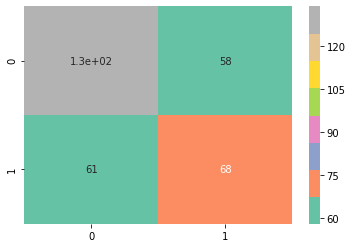

In [12]:
sns.heatmap(cm,
           annot=True,
           cmap="Set2")
plt.show()

In [52]:
from sklearn.metrics import classification_report

In [53]:
labelNames=['male','female']
# evaluate the model
print("[INFO] evaluating model...")
predictions = model.predict(testData)
print(classification_report(testLabels,predictions, target_names=labelNames))

[INFO] evaluating model...
              precision    recall  f1-score   support

        male       0.84      0.95      0.90       359
      female       0.93      0.78      0.85       283

    accuracy                           0.88       642
   macro avg       0.89      0.87      0.87       642
weighted avg       0.88      0.88      0.87       642



In [54]:
import itertools

Confusion matrix, without normalization
[[342  17]
 [ 63 220]]


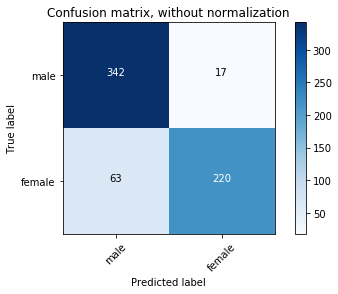

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# y_pred = model.predict(X_test)
# y_pred=np.argmax(y_pred, axis=1) 
# test_y=np.argmax(test_y, axis=1)

# print(y_pred)
# print(test_y)

# Compute confusion matrix
# cnf_matrix = confusion_matrix(test_y, y_pred)
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=labelNames,
                      title='Confusion matrix, without normalization')

plt.show()
# plt.savefig('conf1.png')

# Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=labelNames, normalize=True,
#                       title='Normalized confusion matrix')
# plt.savefig('conf2.png')


In [56]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [57]:
cm_norm

array([[0.95264624, 0.04735376],
       [0.22261484, 0.77738516]])

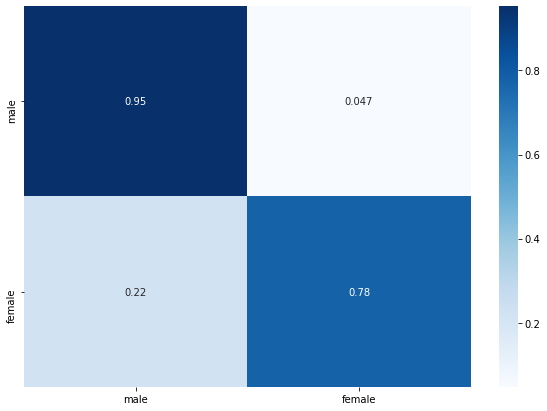

In [58]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[0.95264624, 0.04735376],
       [0.22261484, 0.77738516]]
df_cm = pd.DataFrame(array, index = [i for i in labelNames],
                  columns = [i for i in labelNames])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.savefig('norm_cm_mlp.png')

In [277]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input


from sklearn.linear_model import LogisticRegression
import numpy as np
import os
import pickle
import json


In [278]:
config={
    "model" : "vgg16",
    "weights": "imagenet",
    
    "features_path" : "./Model/features.h5",
    "labels_path" : "./Model/labels.h5",
    "classifier_path" : "./Model/classifier.pickle",
    "model_path" : "./Model/model",

}

In [279]:
print("[info] loading the classfier...")
classifier = pickle.load(open(config["classifier_path"], 'rb'))

if config["model"] == "vgg16":
    base_model = VGG16(weights=config["weights"])
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224,224)
    
else:
    base_model = None
    

[info] loading the classfier...


C:\Users\Mehrtoos\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  


In [312]:
img = image.load_img('./Data/all/im235.jpg', target_size=image_size)
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)
feature = model.predict(x)
flat = feature.flatten()
flat = np.expand_dims(flat, axis=0)
preds = classifier.predict(flat)

In [313]:
preds

array([0], dtype=int64)

In [314]:
label_check1 = ['male', 'female']

In [315]:
label_check1[preds[0]]

'male'

In [316]:
preds[0]

0

In [82]:
import numpy as np
X,y=[],[]
for index, row in wiki_gender.iterrows():
    val=row['pixels'].split(",")
    X.append(np.array(val,'float32'))
    y.append(row['gender'])

In [2]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')


face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')




In [3]:
cap=cv2.VideoCapture(1)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('male', 'female')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

ValueError: Error when checking input: expected conv2d_1_input to have shape (100, 100, 1) but got array with shape (48, 48, 1)

In [ ]:
def make_prediction(path):
    #converting image to gray scale and save it
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path, gray)
    
    #detect face in image, crop it then resize it then save it
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        face_clip = img[y:y+h, x:x+w]
        cv2.imwrite(path, cv2.resize(face_clip, (350, 350)))
    
    #read the processed image then make prediction and display the result
    read_image = cv2.imread(path)
    read_image = read_image.reshape(1, read_image.shape[0], read_image.shape[1], read_image.shape[2])
    read_image_final = read_image/255.0  #normalizing the image
    
    VGG_Pred = model_VGG.predict(read_image_final)  #creating bottleneck features of image using VGG-16.
    VGG_Pred = VGG_Pred.reshape(1, VGG_Pred.shape[1]*VGG_Pred.shape[2]*VGG_Pred.shape[3])
    top_pred = model_top.predict(VGG_Pred)  #making prediction from our own model.
    emotion_label = top_pred[0].argmax() + 1
    print("Predicted Expression Probabilities")
    print("Male: {}\nFemale: {}\n\n".format(top_pred[0][0], top_pred[0][1]))
    print("Dominant Probability = "+str(EMOTION_DICT[emotion_label])+": "+str(max(top_pred[0])))

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.applications import VGG16
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [ ]:
EMOTION_DICT = {1:"male", 2:"female"}
model_VGG = VGG16(weights='imagenet', include_top=False)
model_top = load_model("../Data/Model_Save/model.h5")

In [ ]:
def make_prediction(path):
    #converting image to gray scale and save it
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path, gray)
    
    #detect face in image, crop it then resize it then save it
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        face_clip = img[y:y+h, x:x+w]
        cv2.imwrite(path, cv2.resize(face_clip, (350, 350)))
    
    #read the processed image then make prediction and display the result
    read_image = cv2.imread(path)
    read_image = read_image.reshape(1, read_image.shape[0], read_image.shape[1], read_image.shape[2])
    read_image_final = read_image/255.0  #normalizing the image
    VGG_Pred = model_VGG.predict(read_image_final)  #creating bottleneck features of image using VGG-16.
    VGG_Pred = VGG_Pred.reshape(1, VGG_Pred.shape[1]*VGG_Pred.shape[2]*VGG_Pred.shape[3])
    top_pred = model_top.predict(VGG_Pred)  #making prediction from our own model.
    emotion_label = top_pred[0].argmax() + 1
    print("Predicted Expression Probabilities")
    print("ANGRY: {}\nDISGUST: {}\nFEAR: {}\nHAPPY: {}\nNEUTRAL: {}\nSAD: {}\nSURPRISE: {}\n\n".format(top_pred[0][0], top_pred[0][1], top_pred[0][2], top_pred[0][3], top_pred[0][4], top_pred[0][5], top_pred[0][6]))
    print("Dominant Probability = "+str(EMOTION_DICT[emotion_label])+": "+str(max(top_pred[0])))